# Germinal center replay modeling

In [1]:
# NBVAL_IGNORE_OUTPUT

import numpy as np
import matplotlib.pyplot as plt

from gcdyn import bdms, gpmap, mutators, poisson, utils
from experiments import replay

/opt/miniconda3/envs/gcdyn/lib/python3.9/site-packages/ete3-3.1.2-py3.7.egg/ete3/evol/parser/codemlparser.py:221: SyntaxWarning: "is" with a literal. Did you mean "=="?
/opt/miniconda3/envs/gcdyn/lib/python3.9/site-packages/ete3-3.1.2-py3.7.egg/ete3/evol/parser/codemlparser.py:221: SyntaxWarning: "is" with a literal. Did you mean "=="?


## Parameters

Genotype-phenotype map based on additive DMS binding effects

In [2]:
gp_map = gpmap.AdditiveGPMap(replay.bind_df, nonsense_phenotype=replay.bind_df.min().min())
assert gp_map(replay.NAIVE_SEQUENCE) == 0

Response functions

In [3]:
birth_response = poisson.SigmoidResponse(xscale=1.0, xshift=1.0, yscale=4.0, yshift=0.1)
# birth_response = poisson.ConstantResponse(1.0)
death_response = poisson.ConstantResponse(1.0)
mutation_response = poisson.SequenceContextMutationResponse(replay.mutability,
                                                            replay.seq_to_contexts,
                                                            mutation_intensity=1.0)

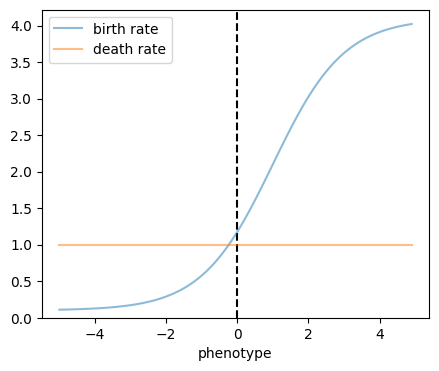

In [4]:
# NBVAL_IGNORE_OUTPUT

x_grid = np.arange(-5, 5, 0.1)

plt.figure(figsize=(5, 4))
plt.axvline(0, color="k", linestyle="--")
plt.plot(x_grid, birth_response.λ_phenotype(x_grid), label="birth rate", alpha=0.5)
plt.plot(x_grid, death_response.λ_phenotype(x_grid), label="death rate", alpha=0.5)
# plt.fill_between(x_grid, mutator.prob(0, x_grid), color="grey", label="distribution of phenotypic\neffects of mutations", alpha=0.5)
plt.xlabel('phenotype')
# plt.ylabel('event rate')
plt.ylim(0, None)
plt.legend()
plt.show()

Mutator

In [5]:
mutator = mutators.SequencePhenotypeMutator(mutators.ContextMutator(mutability=replay.mutability,
                                                                    substitution=replay.substitution,
                                                                    seq_to_contexts=replay.seq_to_contexts),
                                            gp_map)

## Simulate

In [6]:
rng = np.random.default_rng(seed=0)

In [7]:
time = 20
capacity = 50
init_population = 10

In [8]:
for iter in range(1000):
    try:
        tree = bdms.TreeNode(sequence=replay.NAIVE_SEQUENCE, x=gp_map(replay.NAIVE_SEQUENCE))
        tree.evolve(
            time,
            birth_response,
            death_response,
            mutation_response,
            mutator,
            capacity=capacity,
            init_population=init_population,
            min_survivors=capacity // 2,
            capacity_method="birth",
            birth_mutations=False,
            seed=rng,
            verbose=False,
        )
        print(f"try {iter + 1} succeeded, tip count: {len(tree)}")
        break
    except bdms.TreeError as e:
        print(f"try {iter + 1} failed, {e}", flush=True)
        continue

try 1 failed, 'number of survivors 0 is less than min_survivors=25'
try 2 failed, 'number of survivors 0 is less than min_survivors=25'
try 3 succeeded, tip count: 529


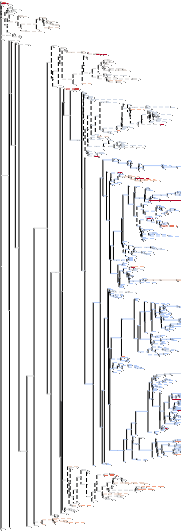

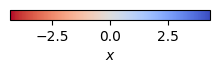

In [9]:
# NBVAL_SKIP

tree.render("%%inline")

Population size history

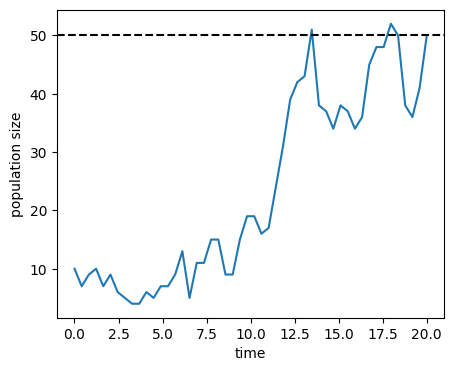

In [10]:
t_grid = np.linspace(0.001, time)
n_t = [len(tree.slice(t)) for t in t_grid]
plt.figure(figsize=(5, 4))
plt.plot(t_grid, n_t)
plt.axhline(capacity, color="k", linestyle="--")
plt.xlabel("time")
plt.ylabel("population size")
plt.show()

In [11]:
tree.sample_survivors(n=50, seed=rng)
tree.prune()

Mean affinity of sampled cells

In [12]:
np.mean([leaf.x for leaf in tree])

0.5283982

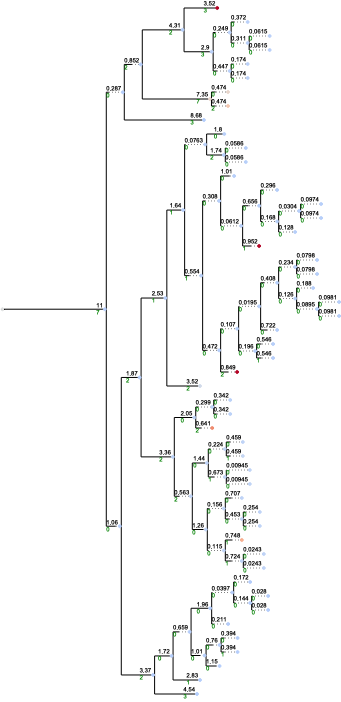

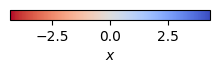

In [13]:
# NBVAL_SKIP

tree.render("%%inline")

In [14]:
tree.total_mutations = 0

for node in tree.iter_descendants(strategy="preorder"):
    node.total_mutations = node.n_mutations + node.up.total_mutations

[leaf.total_mutations for leaf in tree.iter_leaves()]

[14,
 14,
 14,
 14,
 14,
 14,
 16,
 18,
 10,
 11,
 13,
 13,
 12,
 12,
 12,
 12,
 12,
 13,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 13,
 14,
 12,
 11,
 11,
 13,
 13,
 14,
 14,
 14,
 13,
 13,
 13,
 14,
 14,
 14,
 9,
 9,
 9,
 9,
 9,
 10,
 9,
 10,
 12]

In [15]:
# Optionally write out tree and sequences.

if False:
    with open("tree.nwk", "w") as fp:
        fp.write(tree.write()+"\n")

    utils.write_leaf_sequences_to_fasta(tree, "seqs.fasta", naive=replay.NAIVE_SEQUENCE)